<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-первому-шагу:" data-toc-modified-id="Вывод-по-первому-шагу:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод по первому шагу:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Сделаем-более-точный-разбор" data-toc-modified-id="Сделаем-более-точный-разбор-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сделаем более точный разбор</a></span></li><li><span><a href="#Выводы-по-анализу:" data-toc-modified-id="Выводы-по-анализу:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Выводы по анализу:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from scipy import stats as st
from math import factorial
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn import svm

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

Загружаем библиотеки

In [3]:
try:
    taxi=pd.read_csv('/Users/konstantingrigorev/Desktop/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Загружаем датасет, и приводим дату в правильный вид

In [4]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


всё хорошо отображается

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нету, с данными всё хорошо

In [6]:
taxi = taxi.resample('1H').sum()


Делаем ресемплирование

In [7]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [8]:
taxi.describe()


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Получаем такую описательную статистику, на вид всё хорошо

In [9]:
 print('Количество дупликатов в таблице: \n', taxi.reset_index().duplicated().sum())


Количество дупликатов в таблице: 
 0


### Вывод по первому шагу: 
- Дубликатов нету
- Пропусков нету
- Было выполнено ресепмлирование по часу

## Анализ

In [10]:
taxi.index.min()

Timestamp('2018-03-01 00:00:00', freq='H')

In [11]:
taxi.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

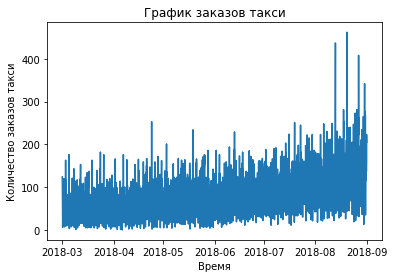

In [12]:
plt.plot(taxi)
plt.xlabel('Время')
plt.ylabel('Количество заказов такси')
plt.title('График заказов такси')
plt.show()


In [13]:
taxi_1 = taxi.copy()
taxi_1['rolling_mean'] = taxi_1['num_orders'].shift().rolling(12).mean()
taxi_1['std'] = taxi_1['num_orders'].rolling(12).std()

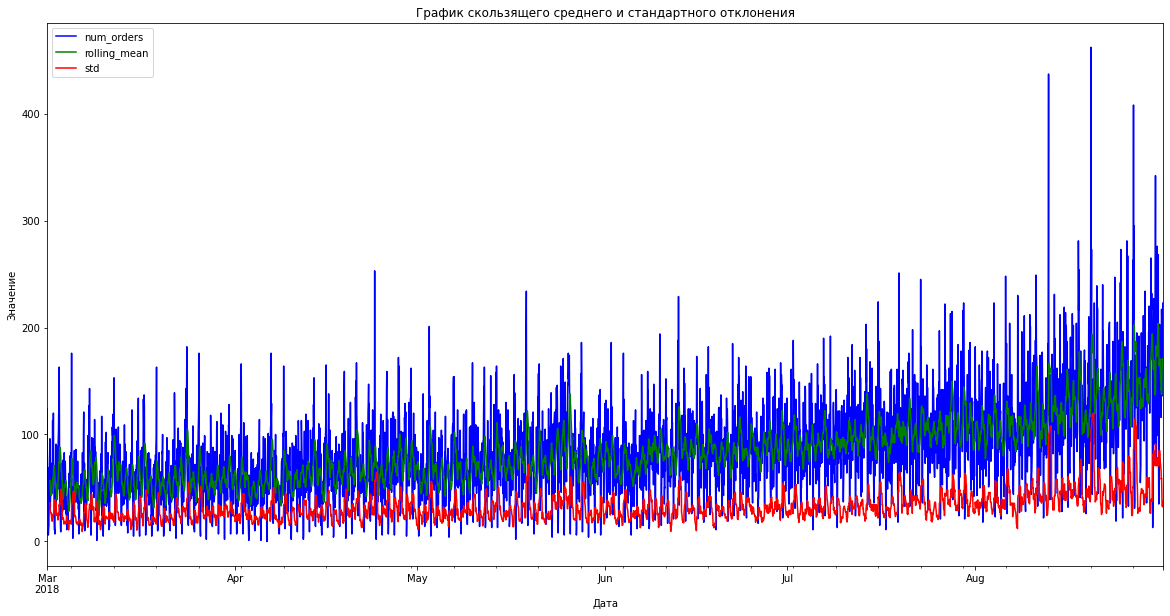

In [14]:
ax = taxi_1.plot(figsize=([20,10]), color=['blue', 'green', 'red'])
ax.set_xlabel('Дата')
ax.set_ylabel('Значение')
ax.set_title('График скользящего среднего и стандартного отклонения')

plt.show()

Из графика можно понять несколько моментов:
- Среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный
- Есть увеличение заказов к осени


### Сделаем более точный разбор

In [15]:
decomposed = seasonal_decompose(taxi) 


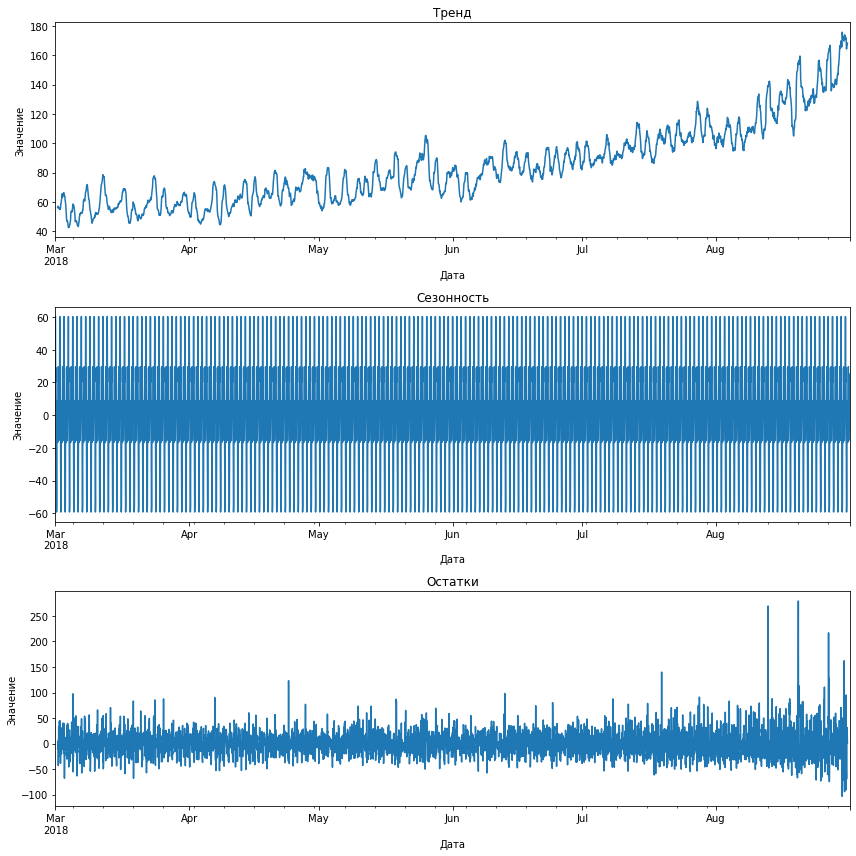

In [16]:

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Значение')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Значение')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.xlabel('Дата')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()



 Случайная составляющая также имеет постоянное среднее значение, однако время от времени наблюдаются значительные всплески. Тренд демонстрирует линейный рост количества заказов с течением времени. 

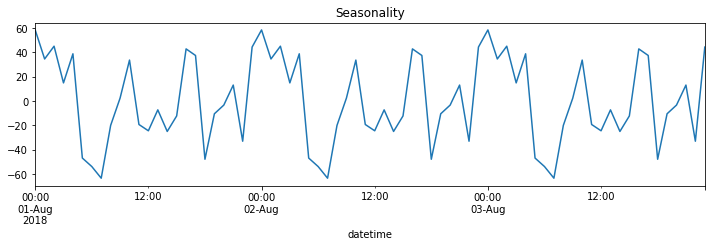

In [17]:
plt.title('Seasonality')
seasonal_decompose(taxi['2018-08-01':'2018-08-03']).seasonal.plot(figsize=(12, 3))
plt.show()

Сделали чуть по-другому сезонность, потому что на прошлом графике каша, тут видно некоторые особеннотси:
- Вечерний Пик заказов происходит примерно с 20:00 до 23:00
- Уттренний пик происходит примерно с 7 до 9 утра

### Выводы по анализу:
- Среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный
- Есть увеличение заказов к осени
- Случайная составляющая также имеет постоянное среднее значение, однако время от времени наблюдаются значительные всплески. Тренд демонстрирует линейный рост количества заказов с течением времени. 
- Вечерний Пик заказов происходит примерно с 20:00 до 23:00
- Утренний пик происходит примерно с 7 до 9 утра

## Обучение

In [18]:





def make_features(data, max_lag, rolling):
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(2*lag)
 
    for i, roll in zip(range(len(rolling)), rolling):
        data['rolling_mean_{}'.format(i)] = data['num_orders'].shift().rolling(roll).mean()

rolling = [5, 13]
make_features(taxi, 8, rolling)

X_train, X_test, y_train, y_test = train_test_split(
    taxi.drop(['num_orders'], axis=1), taxi['num_orders'], test_size=0.1, shuffle=False, random_state=91) 

tscv = TimeSeriesSplit(n_splits=3) 

catboost_grid = {
    'depth': [4, 6],
    'min_data_in_leaf': [3, 5],
    'l2_leaf_reg': [3, 9]
}

catboost_model = CatBoostRegressor(loss_function='RMSE',
                                   verbose=False,
                                   thread_count=-1,
                                   random_seed=91,
                                   iterations=400)

grid_search_catboost = GridSearchCV(catboost_model, catboost_grid, cv=tscv, scoring='neg_root_mean_squared_error')

grid_search_catboost.fit(X_train, y_train)

best_catboost_model = grid_search_catboost.best_estimator_
best_params_catboost = grid_search_catboost.best_params_

test_rmse_catboost = mean_squared_error(y_test, best_catboost_model.predict(X_test), squared=False)

# Оценка качества модели по кросс-валидации
cv_rmse_catboost = grid_search_catboost.best_score_

print("Лучшие параметры с GridSearchCV по CatBoost:")
print(best_params_catboost)
# print("RMSE на тестовых данных для CatBoost:", test_rmse_catboost)
print("Среднее RMSE на кросс-валидации для for CatBoost:", -cv_rmse_catboost)


Лучшие параметры с GridSearchCV по CatBoost:
{'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 3}
Среднее RMSE на кросс-валидации для for CatBoost: 27.53350690223138


CatBoost показал 28 по кросвалидации и 45 по тесту, что удовлетворяет условию, но далее еще опробуем линейную регрессию и случайный лес.

In [19]:
imputer = SimpleImputer(strategy='mean')

features_train_imputed = imputer.fit_transform(X_train)
features_test_imputed = imputer.transform(X_test)

linear_model = LinearRegression()

linear_model.fit(features_train_imputed, y_train)

linear_pred = linear_model.predict(features_test_imputed)

linear_rmse = np.sqrt(mean_squared_error(y_test, linear_pred))
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(features_train_imputed, y_train)

rf_pred = rf_model.predict(features_test_imputed)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
linear_scores = cross_val_score(linear_model, features_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
linear_rmse_cv = np.sqrt(-linear_scores.mean())

rf_scores = cross_val_score(rf_model, features_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
rf_rmse_cv = np.sqrt(-rf_scores.mean())

print("Среднее RMSE на кросс-валидации для линейной регрессии:", linear_rmse_cv)
print("Среднее RMSE на кросс-валидации для случайного леса:", rf_rmse_cv)

Среднее RMSE на кросс-валидации для линейной регрессии: 33.344909537816655
Среднее RMSE на кросс-валидации для случайного леса: 24.832835839016663


Обучаем случайный лес и регрессию

## Тестирование

In [20]:
print("Среднее RMSE на кросс-валидации для линейной регрессии:", linear_rmse_cv)
print("RMSE на тестовых данных для линейной регрессии:", linear_rmse)
print("Среднее RMSE на кросс-валидации для случайного леса:", rf_rmse_cv)
print("RMSE на тестовых данных для случайного леса:", rf_rmse)
print("Среднее RMSE на кросс-валидации для CatBoost:", -cv_rmse_catboost)
print("RMSE на тестовых данных для CatBoost:", test_rmse_catboost)

Среднее RMSE на кросс-валидации для линейной регрессии: 33.344909537816655
RMSE на тестовых данных для линейной регрессии: 56.76809782782695
Среднее RMSE на кросс-валидации для случайного леса: 24.832835839016663
RMSE на тестовых данных для случайного леса: 44.67649060884451
Среднее RMSE на кросс-валидации для CatBoost: 27.53350690223138
RMSE на тестовых данных для CatBoost: 45.30145266647866


Исходя из результатов:

Выводы по оценке качества моделей регрессии:

Линейная регрессия:

- Средняя ошибка (RMSE) на кросс-валидации: 33.34
- Ошибка на тестовых данных: 56.77
- Модель демонстрирует высокую ошибку на тестовых данных.

Случайный лес:

- Средняя ошибка (RMSE) на кросс-валидации: 24.83
- Ошибка на тестовых данных: 44.68
Модель показывает более низкую ошибку на тестовых данных по сравнению с линейной регрессией

CatBoost:

- Средняя ошибка (RMSE) на кросс-валидации: 27.53
- Ошибка на тестовых данных: 45.30

Следовательно, модель случайного леса демонстрирует наилучшее качество прогнозирования

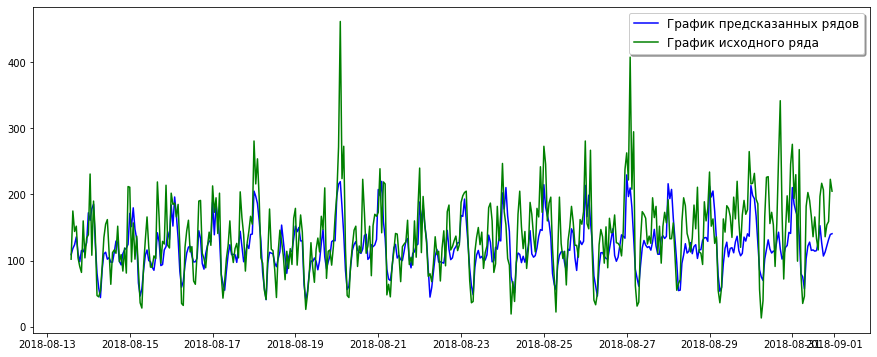

In [21]:

fin_pred_tun = best_catboost_model.predict(X_test)
test_target = y_test

fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(pd.Series(fin_pred_tun, index=test_target.index), label='График предсказанных рядов', color='blue')
ax.plot(test_target, label='График исходного ряда', color='green')

legend = ax.legend(loc='upper right', shadow=True, fontsize=12)

plt.show()


График показывает насколько наша модель правильно предсказывает тестовые данные, видно что есть еще куда расти

### Вывод 

По датасету
- Дубликатов нету
- Пропусков нету
- Было выполнено ресепмлирование по часу

Вывод по анализу:
- Среднее значение и стандартное отклонение со временем увеличиваются, значит временной ряд нестационарный
- Есть увеличение заказов к осени
- Случайная составляющая также имеет постоянное среднее значение, однако время от времени наблюдаются значительные всплески. Тренд демонстрирует линейный рост количества заказов с течением времени. 
- Вечерний Пик заказов происходит примерно с 20:00 до 23:00
- Утренний пик происходит примерно с 7 до 9 утра

Выводы по оценке качества моделей регрессии:

Линейная регрессия:

- Средняя ошибка (RMSE) на кросс-валидации: 33.34
- Ошибка на тестовых данных: 56.77
- Модель демонстрирует высокую ошибку на тестовых данных.

Случайный лес:

- Средняя ошибка (RMSE) на кросс-валидации: 24.83
- Ошибка на тестовых данных: 44.68
Модель показывает более низкую ошибку на тестовых данных по сравнению с линейной регрессией

CatBoost:

- Средняя ошибка (RMSE) на кросс-валидации: 27.53
- Ошибка на тестовых данных: 45.30

Следовательно, модель случайного леса демонстрирует наилучшее качество прогнозирования 